In [1]:
# just spend an hour fixing a problem that didn't exist. All because Jan 1 2033 is a weekend... love bdays
#
# INFO:
#
# All the bank loan amort calcs I found rounded the interest payment amount, and then calculate the total payment 
#  based on the total interest + the principal
#
# TO FIX:
#
# Final x-axis tic set to total payment period amount
#
# Arguably the bonus payment type: seems standard (see below in TO ADD section)
#
# TO ADD:
# M-365 (365/365 or month-actual with 365 days instead of 360
#
# A pie graph that shows total amount paid in interest vs pricipal
#
# add a folder for the imported functions and change the import path
#
# add bar graph monthly payment distribution
#
# add bonus payment type (default=by_periods) (options: yearly, one-time)
#  for yearly: add optional bonus_date parameter (default=start_date)
#    bonus_date would act double as the one-time payment date parameter
#

import os
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import pandas as pd
import calendar
from statistics import mean
import seaborn as sns
import matplotlib.pyplot as plt

# functions created for this project (should create links if I ever share this)
from Required_Functions.validate_date import validate_date
from Required_Functions.business_days import business_days
from Required_Functions.cumulative_values import cumulative_values


def loan_amortization(principal, interest_rate,  term_years, start_date, periodtype="M-30", bonus=0, PLOT=False):
    
    """ 
    Args:
        principal (int or float): The principal amount of the loan.
        interest_rate (int or float): The annual interest rate, expressed as a percent (e.g. 5% = 5).
        term_years (int or float): Loan/Borrowing term in years.
        start_date (str or datetime): The start date of the loan as a string in 'YYYY-MM-DD' format or as a datetime object.
        periodtype (str, default="M-30"): The type of period to use for the loan payments, which can be one of the following:
            'D' (daily)
            'bdays' (daily, only includes business days)
            'W' (weekly)
            'BW' (biweekly)
            'M-30' (months where there is 30 days per month and 360 days per year (30/360))
            'M-Actual' (months where months' lengths are accurate, and there are 360 days per year (Actual/360))
            'Q' (quarterly)
            'S' (semi-annual)
            'Y' (Annual)
        bonus= (int or float, default=0): Optional, additional principal paid per period.
        PLOT= (Bool, default=False): With PLOT set to True, the function will create a folder in the cwd
                                    and download the loan amortization graph as a .png file.
                                - The .png file will have the following naming structure:
                                    - /Loan_Graphs/'Principal_Rate_TermYears_StartDate_PeriodType_bonus.png'
    Returns:
        pandas.DataFrame: A DataFrame containing the amortization schedule for the loan
    """
    # input validation for start_date
    if validate_date(start_date) is False:
        raise TypeError("start_date must be a string in 'YYYY-MM-DD' format or a datetime object")

    # if the date is in the string format, convert it
    if not isinstance(start_date, datetime):
        start_date = datetime.strptime(start_date, '%Y-%m-%d')

    # input type checking for principal, interest_rate, term_years, and bonus
    if not isinstance(principal, (int, float)):
        raise TypeError("Principal amount should be numeric (int or float)")
    if not isinstance(interest_rate, (int, float)):
        raise TypeError("Interest rate should be numeric and in % (int or float)")
    if not isinstance(term_years, (int, float)):
        raise TypeError("term_years should be numeric (int or float)")
    if not isinstance(bonus, (int, float)):
        raise TypeError("bonus should be numeric (int or float)")
    if bonus < 0:
        raise TypeError("bonus should be a positive integer")

    # shift the day forward one when using Daily to assume no payment is made today
    if periodtype == "D":
        start_date = start_date + timedelta(days=1)

    # create end date of term using term_years
    end_date = start_date + relativedelta(years=term_years)

    # create a list of business days for the bday index
    bdays_dates = business_days(start_date, end_date)

    # create a list of weeks for weekly and biweekly index, starting at second week
    week_range = pd.date_range(start=start_date + pd.Timedelta(weeks=1) + pd.Timedelta(days=1), periods=52*term_years, freq='W')
    week_list = [f'{date.week}-{date.year}' for date in week_range]

    # force start and end date to first day of month for month indexing (luv u feb)
    start_date_first = datetime(start_date.year, start_date.month, 1)
    end_date_first = datetime(end_date.year, end_date.month, 1)

    # shift start_date_first forward one month
    if start_date_first.month == 12:
        # handle special case where the month is December
        new_month = 1
        new_year = start_date_first.year + 1
    else:
        new_month = start_date_first.month + 1
        new_year = start_date_first.year
    start_date_p1 = start_date_first.replace(year=new_year, month=new_month)
    # shift end_date_first forward one month
    if end_date_first.month == 12:
        # handle special case where the month is December
        new_month = 1
        new_year = end_date_first.year + 1
    else:
        new_month = end_date_first.month + 1
        new_year = end_date_first.year
    end_date_first_p1 = end_date_first.replace(year=new_year, month=new_month)

    # create month_dates index
    month_dates = [start_date_p1.strftime("%m""-""%Y")]
    month_dates_4D = [start_date_p1]
    current_date = start_date_p1
    while current_date < end_date_first_p1:
        current_date += relativedelta(months=1)
        month_dates_4D.append(current_date)
        month_dates.append(current_date.strftime("%m""-""%Y"))
    # remove last month because 1 is start_date
    month_dates.pop()
    month_dates_4D.pop()

    # create list of days in the month of each date
    days_in_month = [calendar.monthrange(date.year, date.month)[1] for date in month_dates_4D]

    # period-type definition
    if periodtype == 'D':
        periods = int((end_date - start_date).days)
        adjusted_rate = interest_rate / 36525
    elif periodtype == 'bdays':
        periods = len(bdays_dates)
        adjusted_rate = interest_rate / 26100
    elif periodtype == 'W':
        periods = int(52 * term_years)
        adjusted_rate = interest_rate / 5200
    elif periodtype == 'BW':
        periods = int((52 * term_years) / 2)
        adjusted_rate = interest_rate / 2600
    elif periodtype == 'M-30':
        periods = int(12 * term_years)
        adjusted_rate = interest_rate / 1200
    elif periodtype == 'M-Actual':
        periods = int(12 * term_years)
        monthly_rate = [interest_rate / 36000 * days_in_month[i] for i in range(len(month_dates))]
        adjusted_rate = mean(monthly_rate)
    elif periodtype == 'Y':
        periods = term_years
        adjusted_rate = interest_rate / 100
    elif periodtype == 'S':
        periods = int(len(month_dates[1::6]))
        adjusted_rate = interest_rate / 200
    elif periodtype == 'Q':
        periods = int(len(month_dates[1::3]))
        adjusted_rate = interest_rate / 400
    else:
        raise TypeError("periodtype should be one of the following: 'D', 'W', 'BW', 'bdays', 'M-30', 'M-Actual', 'Q', 'S', 'Y'")

    # find payment amount
    monthly_payment = (principal * adjusted_rate / (1 - (1 + adjusted_rate) ** (-periods)))
    monthly_payment_fmt = "{:,.2f}".format(monthly_payment)
    monthly_for_plot = f"{monthly_payment_fmt} + {bonus}"
    actual_payment = (principal * adjusted_rate / (1 - (1 + adjusted_rate) ** (-periods))) + bonus

    # create a list of dates for each payment
    if periodtype == 'M-Actual' or periodtype == 'M-30':
        payment_dates = month_dates
    elif periodtype == 'Y':
        payment_dates = [(start_date + relativedelta(years=1 * i)).year for i in range(periods)]
    elif periodtype == 'bdays':
        payment_dates = bdays_dates
    elif periodtype == 'W':
        payment_dates = week_list
    elif periodtype == 'BW':
        payment_dates = week_list[::2]
    elif periodtype == 'S':
        month_dates.insert(0, start_date.strftime("%m""-""%Y"))
        payment_dates = month_dates[:-6:6]
    elif periodtype == 'Q':
        payment_dates = month_dates[1::3]
    else:
        payment_dates_nfmt = [start_date + relativedelta(days=(i)) for i in range(periods)]
        payment_dates = []
        for elem in payment_dates_nfmt:
            dates_formatted = elem.strftime('%Y-%m-%d')
            payment_dates.append(dates_formatted)

    # lists for the payment number, payment amount, interest, principal, and balance
    payment_number = list(range(1, periods + 1))
    payment_amount = [actual_payment] * periods
    interest = []
    principal_paid = []
    beg_balance = [principal]
    end_balance = []
    pct_interest = []
    pct_principal = []
    bonus_list = [bonus] * periods

    # interest, principal, and balance for each payment period (exlcuding M-actual)
    if not periodtype == "M-Actual":
        for i in range(periods):
            interest.append(beg_balance[i] * adjusted_rate)
            principal_paid.append((monthly_payment) - interest[i])
            beg_balance.append(beg_balance[i] - principal_paid[i] - bonus)
            end_balance.append(beg_balance[i] - principal_paid[i] - bonus)
            pct_interest.append((interest[i] / payment_amount[i]) * 100)
            pct_principal.append(((principal_paid[i] + bonus) / payment_amount[i]) * 100)
    elif periodtype == "M-Actual":
        for i in range(periods):
            interest.append((beg_balance[i] * monthly_rate[i]))
            principal_paid.append((monthly_payment) - interest[i])
            beg_balance.append(beg_balance[i] - principal_paid[i] - bonus)
            end_balance.append(beg_balance[i] - principal_paid[i] - bonus)
            pct_interest.append((interest[i] / payment_amount[i]) * 100)
            pct_principal.append(((principal_paid[i] + bonus) / payment_amount[i]) * 100)
        principal_paid[-1] = beg_balance[-2]
        payment_amount[-1] = principal_paid[-1] + interest[-1]
        end_balance[-1] = 0

    # if bonus > 0: do fake amortization without bonus for calc of interest saved
    if bonus > 0:
        interest2 = []
        principal_paid2 = []
        beg_balance2 = [principal]
        end_balance2 = []
        if not periodtype == "M-Actual":
            for i in range(periods):
                interest2.append(beg_balance2[i] * adjusted_rate)
                principal_paid2.append((monthly_payment) - interest2[i])
                beg_balance2.append(beg_balance2[i] - principal_paid2[i])
                end_balance2.append(beg_balance2[i] - principal_paid2[i])
        elif periodtype == "M-Actual":
            for i in range(periods):
                interest2.append((beg_balance2[i] * monthly_rate[i]))
                principal_paid2.append((monthly_payment) - interest2[i])
                beg_balance2.append(beg_balance2[i] - principal_paid2[i])
                end_balance2.append(beg_balance2[i] - principal_paid2[i])

    # make the amortization-schedule dataframe
    data = {
        'Payment Number': payment_number,
        'Payment Date': payment_dates,
        'Beginning Balance': beg_balance[:-1],
        'Payment Amount': payment_amount,
        'Bonus': bonus_list,
        'Interest Paid': interest,
        'Principal Paid': principal_paid,
        'Ending Balance': end_balance,
        '% Paid In Interest': pct_interest,
        '% Paid To Principal': pct_principal
    }
    # dataframe creation
    df = pd.DataFrame(data)

    # truncate df with bonus
    if bonus > 0:
        index_balance = (df['Ending Balance'] <= 0).idxmax()
        df = df.iloc[:index_balance + 1]
        df["Principal Paid"].iloc[-1] = df["Beginning Balance"].iloc[-1]
        df["Payment Amount"].iloc[-1] = df["Principal Paid"].iloc[-1] + df["Interest Paid"].iloc[-1]
        df["Bonus"].iloc[-1] = 0
        df["Ending Balance"].iloc[-1] = 0
        periods_b4save = periods
        periods = int(len(df.index))
        # find amount saved by extra payment
        amount_saved_nfmt = sum(interest2) - df["Interest Paid"].sum()
        amount_saved = "{:,.2f}".format(amount_saved_nfmt)
        # find periods saved
        periods_saved = periods_b4save - periods

    # create stats for plot
    # create total interest ****
    total_interest_nfmt = df["Interest Paid"].sum()
    total_interest = "{:,.2f}".format(total_interest_nfmt)

    # create total payment
    total_payment_nfmt = total_interest_nfmt + principal
    total_payment = "{:,.2f}".format(total_payment_nfmt)

    # format data for graph
    if bonus > 0:
        start_value = 0
        loan_balance_list = df["Ending Balance"].tolist()
        loan_balance = loan_balance_list.copy()
        loan_balance.insert(0, principal)
        interest_list = df["Interest Paid"].tolist()
        cumulative_interest_list = cumulative_values(interest_list)
        cumulative_interest = cumulative_interest_list.copy()
        cumulative_interest.insert(0, start_value)
        principal_paid_list = df["Principal Paid"].tolist()
        principal_paid_plot = [x + bonus if i < len(principal_paid_list)-1 else x for i, x in enumerate(principal_paid_list)] 
        cumulative_principal_list = cumulative_values(principal_paid_plot)
        cumulative_principal = cumulative_principal_list.copy()
        cumulative_principal.insert(0, start_value)
    else:
        start_value = 0
        loan_balance = end_balance.copy()
        loan_balance.insert(0, principal)
        cumulative_interest_list = cumulative_values(interest)
        cumulative_interest = cumulative_interest_list.copy()
        cumulative_interest.insert(0, start_value)
        cumulative_principal_list = cumulative_values(principal_paid)
        cumulative_principal = cumulative_principal_list.copy()
        cumulative_principal.insert(0, start_value)

    # set index to dates
    df.set_index('Payment Date', inplace=True)
    if periodtype == "M-Actual" or periodtype == "M-30" or periodtype == "Q" or periodtype == "S":
        df.index.name = "Payment Month"
    elif periodtype == "W" or periodtype == "BW":
        df.index.name = "Payment Week"
    elif periodtype == "Y":
        df.index.name = "Payment Year"
    else:
        df.index.name = 'Payment Date'

    # apply formating for dollar signs and two decimals (new df to retain old format)
    df['Payment Amount'] = df['Payment Amount'].apply(lambda x: '${:,.2f}'.format(x))
    df['Interest Paid'] = df['Interest Paid'].apply(lambda x: '${:,.2f}'.format(x))
    df['Principal Paid'] = df['Principal Paid'].apply(lambda x: '${:,.2f}'.format(x))
    df['Beginning Balance'] = df['Beginning Balance'].apply(lambda x: '${:,.2f}'.format(x))
    df['Ending Balance'] = df['Ending Balance'].apply(lambda x: '${:,.2f}'.format(x))
    df['% Paid In Interest'] = df['% Paid In Interest'].apply(lambda x: '{:,.3f}%'.format(x))
    df['% Paid To Principal'] = df['% Paid To Principal'].apply(lambda x: '{:,.3f}%'.format(x))

    plot_data = {
        'Loan Balance': loan_balance,
        'Cumulative Interest': cumulative_interest,
        'Principal Paid': cumulative_principal
    }

    # make plot
    plot = sns.lineplot(data=plot_data)
    
    # find period amount
    df_length = len(df["Payment Amount"])
    index_name = df.index.name

    # tweak visual aspects of plot
    plot.set_title(f"Loan Amortization Graph (${principal:,}|{interest_rate}%|{term_years} years|{periodtype})")
    plot.set_xlabel(f"Payment Number (Total Payments: {df_length})\n(Initial {index_name}: {df.index[0]} | Final {index_name}: {df.index[-1]})")
    plot.set_ylabel("Amount (in Dollars)")
    plt.grid(True)
    plot.set_xlim(0, periods)
    plot.set_ylim(0)

    # change line color
    lines = plot.lines
    lines[0].set(color='blue', linestyle='-')
    lines[1].set(color='red', linestyle='-')
    lines[2].set(color='green', linestyle='-')

    # make sure legend matches line color
    ax = plot.axes
    handles, labels = ax.get_legend_handles_labels()
    handles[0].set(color='blue', linestyle='-')
    handles[1].set(color='red', linestyle='-')
    handles[2].set(color='green', linestyle='-')
    ax.legend(handles=handles, labels=labels, loc='center left')

    # add the total stats as annotations
    plt.annotate(f'Total Cost of Loan: ${total_payment}', xy=((periods * .3), (principal)), xytext=((periods * .279), (ax.get_ylim()[1] - (ax.get_ylim()[1] * .045))), bbox=dict(facecolor='white', boxstyle='round'))
    plt.annotate(f'Total Interest Paid: ${total_interest}', xy=((periods * .3), (principal)), xytext=((periods * .2815), (ax.get_ylim()[1] - (ax.get_ylim()[1] * .11))), bbox=dict(facecolor='white', boxstyle='round'))
    plt.annotate(f'Payment: ${monthly_for_plot}', xy=((periods * .3), (principal)), xytext=((periods * .31), (ax.get_ylim()[1] - (ax.get_ylim()[1] * .175))), bbox=dict(facecolor='white', boxstyle='round'))

    # add addition annotations if there is bonus
    if bonus > 0:
        plt.annotate(f'Interest Saved w/ Bonus: ${amount_saved}', xy=((periods * .3), (principal)), xytext=(0 - (periods * .015) , (ax.get_ylim()[1] * 1.095)), bbox=dict(facecolor='white', boxstyle='round'))
        plt.annotate(f'Periods Saved w/ Bonus: {periods_saved}', xy=((periods * .3), (principal)), xytext=(periods - (periods * .365) , (ax.get_ylim()[1] * 1.095)), bbox=dict(facecolor='white', boxstyle='round'))

    # tighen layout of plot for saving
    plt.tight_layout()

    # save plot to graphs folder if PLOT=True
    if PLOT is True:
        if not os.path.exists('loan_graphs'):
            os.makedirs('loan_graphs')
        # save plot with filename based on input parameters
        plot_filename = f"loan_graphs/{principal}_{interest_rate}_{term_years}_{start_date.date()}_{periodtype}_bonus{bonus}.png"
        if not os.path.isfile(plot_filename):  # ensure plot doesn't attmept to save twice
            plt.savefig(plot_filename)

    return df

,Payment Number,Beginning Balance,Payment Amount,Bonus,Interest Paid,Principal Paid,Ending Balance,% Paid In Interest,% Paid To Principal
Payment Month,,,,,,,,,
02-2023,1,"$200,000.00",$898.09,0,$583.33,$314.76,"$199,685.24",64.953%,35.047%
03-2023,2,"$199,685.24",$898.09,0,$582.42,$315.67,"$199,369.57",64.850%,35.150%
04-2023,3,"$199,369.57",$898.09,0,$581.49,$316.59,"$199,052.98",64.748%,35.252%
05-2023,4,"$199,052.98",$898.09,0,$580.57,$317.52,"$198,735.46",64.645%,35.355%
06-2023,5,"$198,735.46",$898.09,0,$579.65,$318.44,"$198,417.01",64.542%,35.458%
...,...,...,...,...,...,...,...,...,...
09-2052,356,"$4,451.42",$898.09,0,$12.98,$885.11,"$3,566.32",1.446%,98.554%
10-2052,357,"$3,566.32",$898.09,0,$10.40,$887.69,"$2,678.63",1.158%,98.842%
11-2052,358,"$2,678.63",$898.09,0,$7.81,$890.28,"$1,788.35",0.870%,99.130%


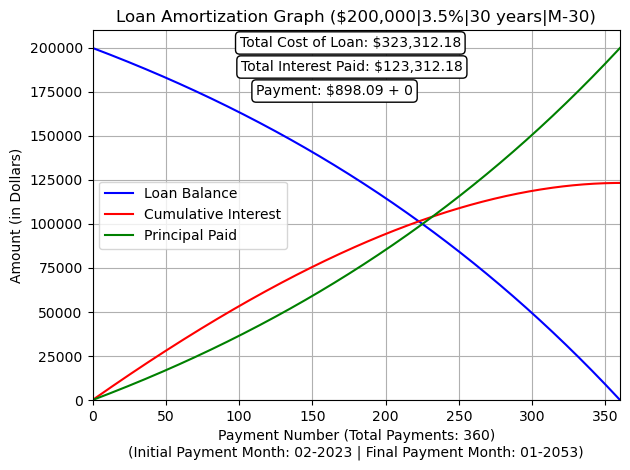

In [2]:
schedule = loan_amortization(200000, 3.5, 30, "2023-1-1", PLOT=True)

schedule

,Payment Number,Beginning Balance,Payment Amount,Bonus,Interest Paid,Principal Paid,Ending Balance,% Paid In Interest,% Paid To Principal
Payment Month,,,,,,,,,
02-2023,1,"$200,000.00","$1,098.09",200,$583.33,$314.76,"$199,485.24",53.123%,46.877%
03-2023,2,"$199,485.24","$1,098.09",200,$581.83,$316.26,"$198,968.99",52.986%,47.014%
04-2023,3,"$198,968.99","$1,098.09",200,$580.33,$317.76,"$198,451.22",52.849%,47.151%
05-2023,4,"$198,451.22","$1,098.09",200,$578.82,$319.27,"$197,931.95",52.711%,47.289%
06-2023,5,"$197,931.95","$1,098.09",200,$577.30,$320.79,"$197,411.16",52.573%,47.427%
...,...,...,...,...,...,...,...,...,...
06-2044,257,"$4,510.96","$1,098.09",200,$13.16,$884.93,"$3,426.03",1.198%,98.802%
07-2044,258,"$3,426.03","$1,098.09",200,$9.99,$888.10,"$2,337.93",0.910%,99.090%
08-2044,259,"$2,337.93","$1,098.09",200,$6.82,$891.27,"$1,246.66",0.621%,99.379%


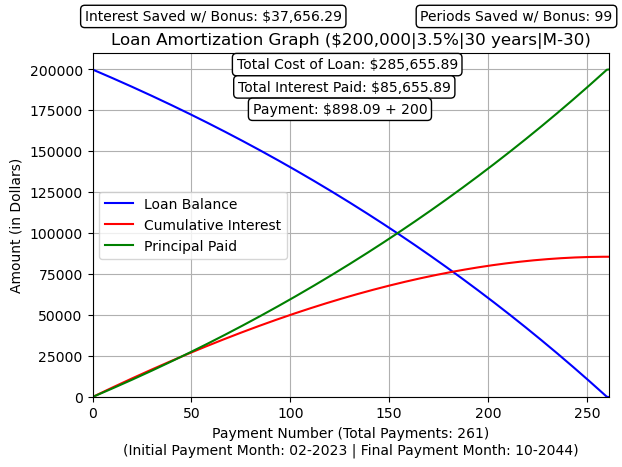

In [3]:
schedule = loan_amortization(200000, 3.5, 30, "2023-1-1", bonus=200, PLOT=True)

schedule

,Payment Number,Beginning Balance,Payment Amount,Bonus,Interest Paid,Principal Paid,Ending Balance,% Paid In Interest,% Paid To Principal
Payment Month,,,,,,,,,
02-2023,1,"$200,000.00",$903.82,0,$544.44,$359.37,"$199,640.63",60.238%,39.762%
03-2023,2,"$199,640.63",$903.82,0,$601.69,$302.12,"$199,338.51",66.573%,33.427%
04-2023,3,"$199,338.51",$903.82,0,$581.40,$322.41,"$199,016.10",64.328%,35.672%
05-2023,4,"$199,016.10",$903.82,0,$599.81,$304.00,"$198,712.09",66.364%,33.636%
06-2023,5,"$198,712.09",$903.82,0,$579.58,$324.24,"$198,387.85",64.126%,35.874%
...,...,...,...,...,...,...,...,...,...
09-2052,356,"$4,404.16",$903.82,0,$12.85,$890.97,"$3,513.19",1.421%,98.579%
10-2052,357,"$3,513.19",$903.82,0,$10.59,$893.23,"$2,619.96",1.172%,98.828%
11-2052,358,"$2,619.96",$903.82,0,$7.64,$896.17,"$1,723.79",0.845%,99.155%


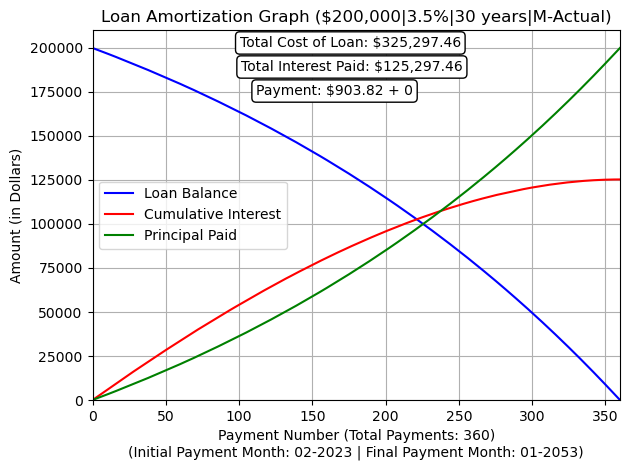

In [4]:
schedule = loan_amortization(200000, 3.5, 30, "2023-1-1", 'M-Actual')

schedule

,Payment Number,Beginning Balance,Payment Amount,Bonus,Interest Paid,Principal Paid,Ending Balance,% Paid In Interest,% Paid To Principal
Payment Month,,,,,,,,,
02-2023,1,"$200,000.00","$1,103.82",200,$544.44,$359.37,"$199,440.63",49.324%,50.676%
03-2023,2,"$199,440.63","$1,103.82",200,$601.09,$302.72,"$198,937.91",54.456%,45.544%
04-2023,3,"$198,937.91","$1,103.82",200,$580.24,$323.58,"$198,414.33",52.566%,47.434%
05-2023,4,"$198,414.33","$1,103.82",200,$598.00,$305.82,"$197,908.51",54.176%,45.824%
06-2023,5,"$197,908.51","$1,103.82",200,$577.23,$326.58,"$197,381.93",52.294%,47.706%
...,...,...,...,...,...,...,...,...,...
05-2044,256,"$5,420.72","$1,103.82",200,$16.34,$887.48,"$4,333.24",1.480%,98.520%
06-2044,257,"$4,333.24","$1,103.82",200,$12.64,$891.18,"$3,242.06",1.145%,98.855%
07-2044,258,"$3,242.06","$1,103.82",200,$9.77,$894.04,"$2,148.02",0.885%,99.115%


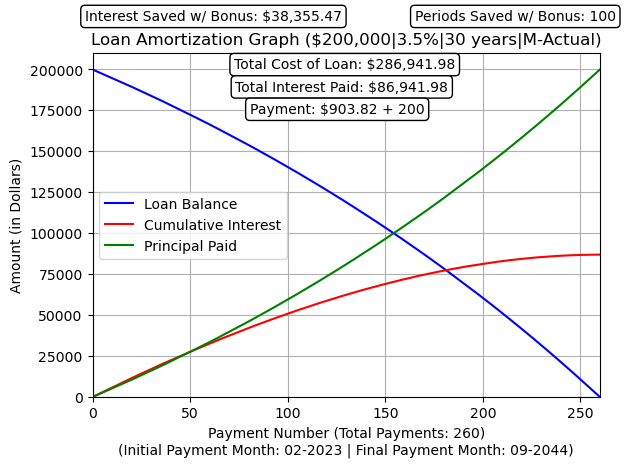

In [5]:
schedule = loan_amortization(200000, 3.5, 30, "2023-1-1", 'M-Actual', bonus=200)

schedule

,Payment Number,Beginning Balance,Payment Amount,Bonus,Interest Paid,Principal Paid,Ending Balance,% Paid In Interest,% Paid To Principal
Payment Date,,,,,,,,,
2023-01-02,1,"$200,000.00",$290.38,0,$32.85,$257.52,"$199,742.48",11.314%,88.686%
2023-01-03,2,"$199,742.48",$290.38,0,$32.81,$257.56,"$199,484.91",11.300%,88.700%
2023-01-04,3,"$199,484.91",$290.38,0,$32.77,$257.61,"$199,227.31",11.285%,88.715%
2023-01-05,4,"$199,227.31",$290.38,0,$32.73,$257.65,"$198,969.66",11.271%,88.729%
2023-01-06,5,"$198,969.66",$290.38,0,$32.68,$257.69,"$198,711.97",11.256%,88.744%
...,...,...,...,...,...,...,...,...,...
2024-12-28,727,"$1,451.17",$290.38,0,$0.24,$290.14,"$1,161.03",0.082%,99.918%
2024-12-29,728,"$1,161.03",$290.38,0,$0.19,$290.19,$870.84,0.066%,99.934%
2024-12-30,729,$870.84,$290.38,0,$0.14,$290.23,$580.61,0.049%,99.951%


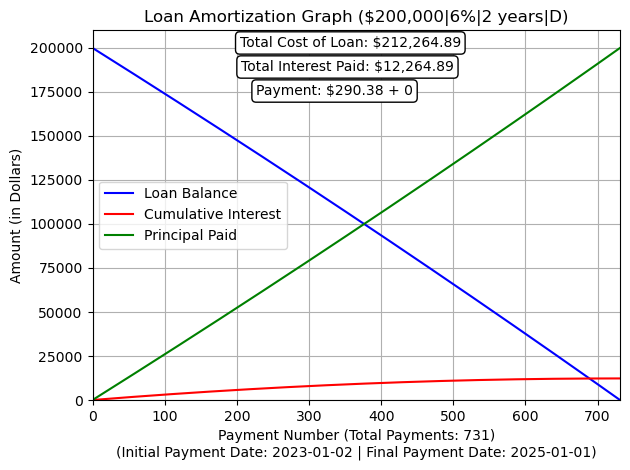

In [6]:
schedule = loan_amortization(200000, 6, 2, "2023-1-1", 'D')

schedule

,Payment Number,Beginning Balance,Payment Amount,Bonus,Interest Paid,Principal Paid,Ending Balance,% Paid In Interest,% Paid To Principal
Payment Date,,,,,,,,,
2023-01-02,1,"$200,000.00",$405.90,0,$45.98,$359.93,"$199,640.07",11.327%,88.673%
2023-01-03,2,"$199,640.07",$405.90,0,$45.89,$360.01,"$199,280.07",11.307%,88.693%
2023-01-04,3,"$199,280.07",$405.90,0,$45.81,$360.09,"$198,919.98",11.286%,88.714%
2023-01-05,4,"$198,919.98",$405.90,0,$45.73,$360.17,"$198,559.80",11.266%,88.734%
2023-01-06,5,"$198,559.80",$405.90,0,$45.65,$360.26,"$198,199.55",11.246%,88.754%
...,...,...,...,...,...,...,...,...,...
2024-12-26,519,"$2,028.11",$405.90,0,$0.47,$405.44,"$1,622.68",0.115%,99.885%
2024-12-27,520,"$1,622.68",$405.90,0,$0.37,$405.53,"$1,217.15",0.092%,99.908%
2024-12-30,521,"$1,217.15",$405.90,0,$0.28,$405.62,$811.52,0.069%,99.931%


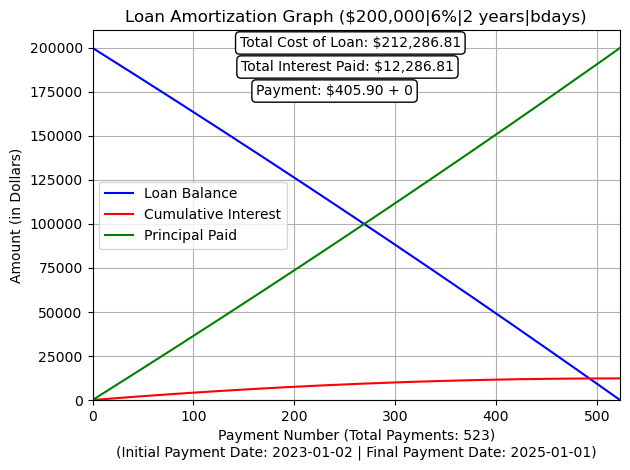

In [7]:
schedule = loan_amortization(200000, 6, 2, "2023-1-1", 'bdays')

schedule

,Payment Number,Beginning Balance,Payment Amount,Bonus,Interest Paid,Principal Paid,Ending Balance,% Paid In Interest,% Paid To Principal
Payment Week,,,,,,,,,
2-2023,1,"$200,000.00",$488.93,0,$192.31,$296.62,"$199,703.38",39.332%,60.668%
3-2023,2,"$199,703.38",$488.93,0,$192.02,$296.91,"$199,406.47",39.274%,60.726%
4-2023,3,"$199,406.47",$488.93,0,$191.74,$297.19,"$199,109.28",39.216%,60.784%
5-2023,4,"$199,109.28",$488.93,0,$191.45,$297.48,"$198,811.80",39.157%,60.843%
6-2023,5,"$198,811.80",$488.93,0,$191.17,$297.76,"$198,514.03",39.099%,60.901%
...,...,...,...,...,...,...,...,...,...
48-2032,516,"$2,437.61",$488.93,0,$2.34,$486.59,"$1,951.03",0.479%,99.521%
49-2032,517,"$1,951.03",$488.93,0,$1.88,$487.05,"$1,463.97",0.384%,99.616%
50-2032,518,"$1,463.97",$488.93,0,$1.41,$487.52,$976.45,0.288%,99.712%


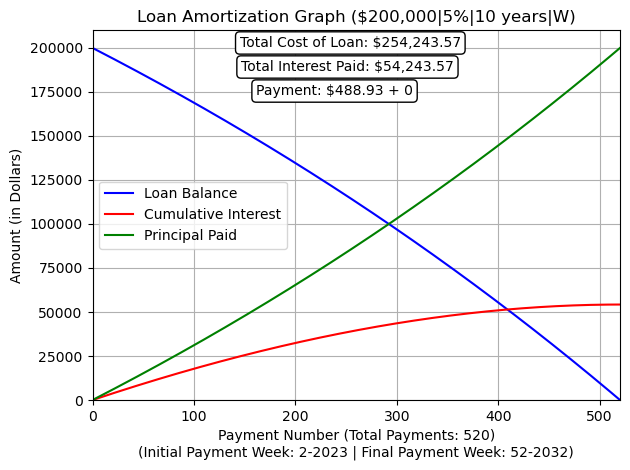

In [8]:
schedule = loan_amortization(200000, 5, 10, "2023-1-1", 'W')

schedule

,Payment Number,Beginning Balance,Payment Amount,Bonus,Interest Paid,Principal Paid,Ending Balance,% Paid In Interest,% Paid To Principal
Payment Week,,,,,,,,,
2-2023,1,"$200,000.00",$978.22,0,$384.62,$593.61,"$199,406.39",39.318%,60.682%
4-2023,2,"$199,406.39",$978.22,0,$383.47,$594.75,"$198,811.65",39.201%,60.799%
6-2023,3,"$198,811.65",$978.22,0,$382.33,$595.89,"$198,215.75",39.084%,60.916%
8-2023,4,"$198,215.75",$978.22,0,$381.18,$597.04,"$197,618.72",38.967%,61.033%
10-2023,5,"$197,618.72",$978.22,0,$380.04,$598.19,"$197,020.53",38.850%,61.150%
...,...,...,...,...,...,...,...,...,...
43-2032,256,"$4,863.02",$978.22,0,$9.35,$968.87,"$3,894.15",0.956%,99.044%
45-2032,257,"$3,894.15",$978.22,0,$7.49,$970.73,"$2,923.41",0.766%,99.234%
47-2032,258,"$2,923.41",$978.22,0,$5.62,$972.60,"$1,950.81",0.575%,99.425%


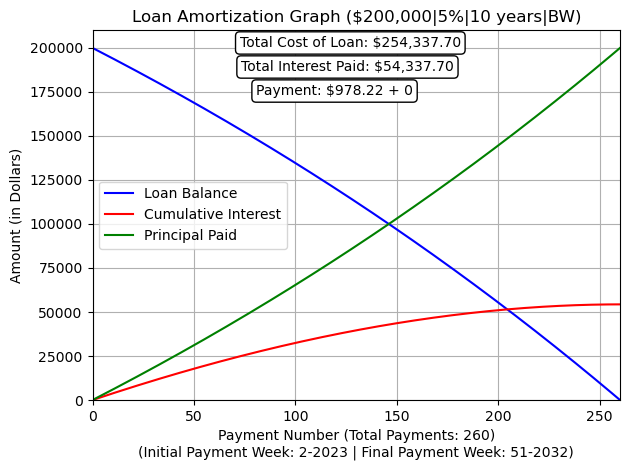

In [9]:
schedule = loan_amortization(200000, 5, 10, "2023-1-1", 'BW')

schedule

,Payment Number,Beginning Balance,Payment Amount,Bonus,Interest Paid,Principal Paid,Ending Balance,% Paid In Interest,% Paid To Principal
Payment Month,,,,,,,,,
03-2023,1,"$200,000.00","$6,391.12",300,"$2,000.00","$4,091.12","$195,608.88",31.293%,68.707%
06-2023,2,"$195,608.88","$6,391.12",300,"$1,956.09","$4,135.03","$191,173.85",30.606%,69.394%
09-2023,3,"$191,173.85","$6,391.12",300,"$1,911.74","$4,179.38","$186,694.47",29.912%,70.088%
12-2023,4,"$186,694.47","$6,391.12",300,"$1,866.94","$4,224.17","$182,170.29",29.212%,70.788%
03-2024,5,"$182,170.29","$6,391.12",300,"$1,821.70","$4,269.42","$177,600.88",28.504%,71.496%
06-2024,6,"$177,600.88","$6,391.12",300,"$1,776.01","$4,315.11","$172,985.77",27.789%,72.211%
09-2024,7,"$172,985.77","$6,391.12",300,"$1,729.86","$4,361.26","$168,324.50",27.067%,72.933%
12-2024,8,"$168,324.50","$6,391.12",300,"$1,683.25","$4,407.87","$163,616.63",26.337%,73.663%
03-2025,9,"$163,616.63","$6,391.12",300,"$1,636.17","$4,454.95","$158,861.68",25.601%,74.399%


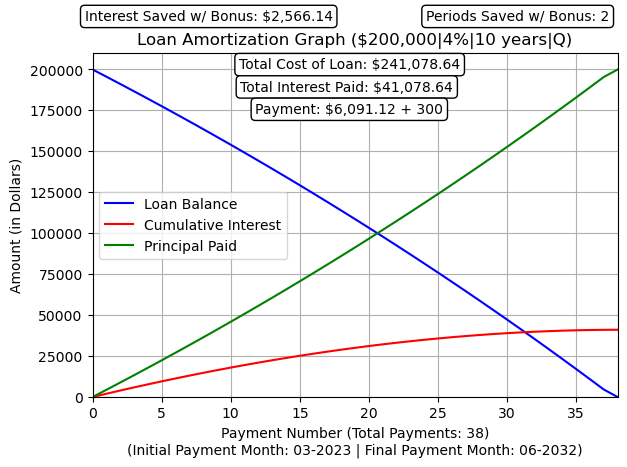

In [10]:
schedule = loan_amortization(200000, 4, 10, "2023-1-1", 'Q', bonus=300)

schedule

,Payment Number,Beginning Balance,Payment Amount,Bonus,Interest Paid,Principal Paid,Ending Balance,% Paid In Interest,% Paid To Principal
Payment Month,,,,,,,,,
01-2023,1,"$200,000.00","$12,231.34",0,"$4,000.00","$8,231.34","$191,768.66",32.703%,67.297%
07-2023,2,"$191,768.66","$12,231.34",0,"$3,835.37","$8,395.97","$183,372.69",31.357%,68.643%
01-2024,3,"$183,372.69","$12,231.34",0,"$3,667.45","$8,563.89","$174,808.80",29.984%,70.016%
07-2024,4,"$174,808.80","$12,231.34",0,"$3,496.18","$8,735.17","$166,073.63",28.584%,71.416%
01-2025,5,"$166,073.63","$12,231.34",0,"$3,321.47","$8,909.87","$157,163.76",27.155%,72.845%
07-2025,6,"$157,163.76","$12,231.34",0,"$3,143.28","$9,088.07","$148,075.69",25.699%,74.301%
01-2026,7,"$148,075.69","$12,231.34",0,"$2,961.51","$9,269.83","$138,805.86",24.212%,75.788%
07-2026,8,"$138,805.86","$12,231.34",0,"$2,776.12","$9,455.23","$129,350.63",22.697%,77.303%
01-2027,9,"$129,350.63","$12,231.34",0,"$2,587.01","$9,644.33","$119,706.30",21.151%,78.849%


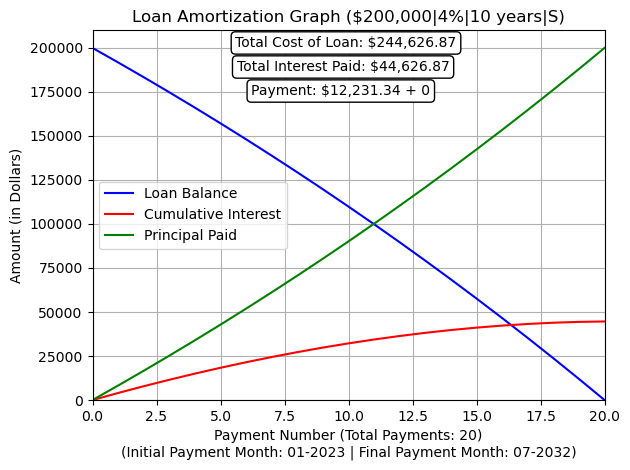

In [11]:
schedule = loan_amortization(200000, 4, 10, "2023-1-1", 'S')

schedule

,Payment Number,Beginning Balance,Payment Amount,Bonus,Interest Paid,Principal Paid,Ending Balance,% Paid In Interest,% Paid To Principal
Payment Year,,,,,,,,,
2023,1,"$200,000.00","$24,958.19",300,"$8,000.00","$16,658.19","$183,041.81",32.054%,67.946%
2024,2,"$183,041.81","$24,958.19",300,"$7,321.67","$17,336.52","$165,405.29",29.336%,70.664%
2025,3,"$165,405.29","$24,958.19",300,"$6,616.21","$18,041.98","$147,063.32",26.509%,73.491%
2026,4,"$147,063.32","$24,958.19",300,"$5,882.53","$18,775.66","$127,987.66",23.570%,76.430%
2027,5,"$127,987.66","$24,958.19",300,"$5,119.51","$19,538.68","$108,148.98",20.512%,79.488%
2028,6,"$108,148.98","$24,958.19",300,"$4,325.96","$20,332.23","$87,516.75",17.333%,82.667%
2029,7,"$87,516.75","$24,958.19",300,"$3,500.67","$21,157.52","$66,059.23",14.026%,85.974%
2030,8,"$66,059.23","$24,958.19",300,"$2,642.37","$22,015.82","$43,743.41",10.587%,89.413%
2031,9,"$43,743.41","$24,958.19",300,"$1,749.74","$22,908.45","$20,534.96",7.011%,92.989%


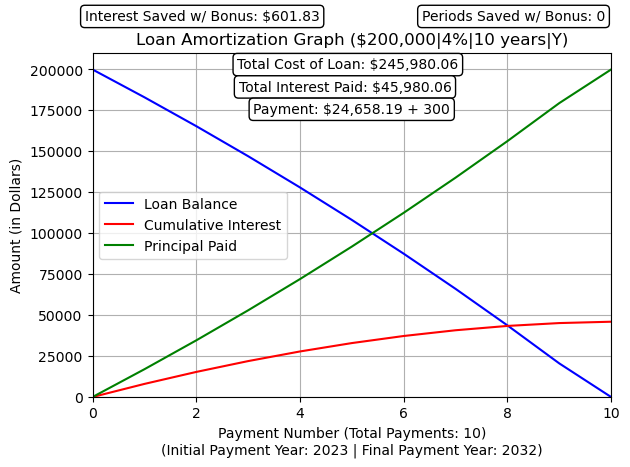

In [12]:
schedule = loan_amortization(200000, 4, 10, "2023-1-1", 'Y', bonus=300)

schedule